In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -qq "/content/gdrive/MyDrive/u-net.zip"

In [ ]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D


In [ ]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import tensorflow as tf
from tensorflow.keras.layers import Input

In [ ]:
labels = pd.read_csv('/content/class_dict_seg.csv')
labels

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [ ]:
len(labels)

24

In [ ]:
labels.name

0       unlabeled
1      paved-area
2            dirt
3           grass
4          gravel
5           water
6           rocks
7            pool
8      vegetation
9            roof
10           wall
11         window
12           door
13          fence
14     fence-pole
15         person
16            dog
17            car
18        bicycle
19           tree
20      bald-tree
21      ar-marker
22       obstacle
23    conflicting
Name: name, dtype: object

In [ ]:
inp_dir = '/content/dataset/semantic_drone_dataset/original_images'

In [ ]:
mask_dir = '/content/RGB_color_image_masks/RGB_color_image_masks'

In [ ]:
inp_list = os.listdir(inp_dir)
mask_list=os.listdir(mask_dir)

inp_list.sort()
mask_list.sort()

inp_img_list = [os.path.join(inp_dir,i) for i in inp_list]

mask_list = [os.path.join(mask_dir,i) for i in mask_list]

In [ ]:
def plt_image_and_mask_by_path(img_list,mask_lst,n=3):
  for i in range(3):
    img1=imageio.imread(img_list[i])
    mask1=imageio.imread(mask_lst[i])
    _,arr = plt.subplots(1,2,figsize=(10,10))
    arr[0].imshow(img1)
    arr[0].axis('off')
    arr[1].imshow(mask1)
    arr[1].axis('off')

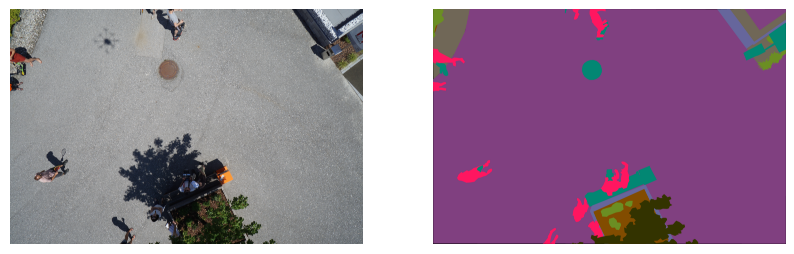

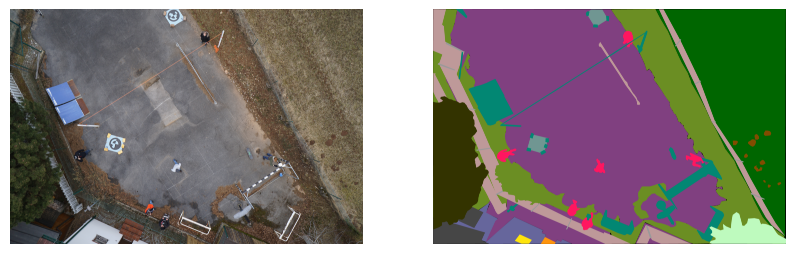

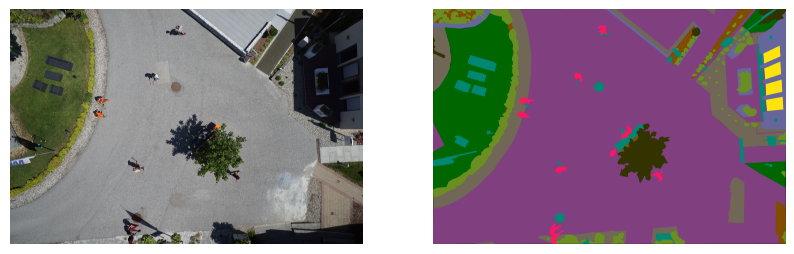

In [ ]:
plt_image_and_mask_by_path(inp_img_list, mask_list,3)

In [ ]:
image_names  = tf.constant(inp_img_list)
mask_names = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_names,mask_names))
for image,mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/content/dataset/semantic_drone_dataset/original_images/000.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/RGB_color_image_masks/RGB_color_image_masks/000.png', shape=(), dtype=string)


In [ ]:
def process_path(image_,mask_):
    img = tf.io.read_file(image_)
    img = tf.image.decode_png(img,channels=3)
    img = tf.image.convert_image_dtype(img,tf.float32)

    mask = tf.io.read_file(mask_)
    mask = tf.image.decode_png(mask,channels=3)
    ## take max of each pixel vector along channels axis, but keep the dimensions
    ## this is to make training faster(at least compared to 3 channeled mask images)
    ## once we do this , true mask images and new mask images differ by colors of each class
    ## and images are reduced in quality
    mask = tf.math.reduce_max(mask,axis=-1,keepdims=True)
    return img,mask

def process(image,mask):
    '''
    reduce the image size
    '''
    inp_image = tf.image.resize(image,(572,572),method='nearest')
    inp_mask = tf.image.resize(mask,(572,572),method='nearest')
    return inp_image,inp_mask

image_ds = dataset.map(process_path)
processed_images_ds = image_ds.map(process)

In [ ]:
def UNet(input_size = (572,572,3)):
    inp = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(inp)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'valid', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inp, outputs=[conv10])

    return model


In [ ]:
model = UNet()
model.summary()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

ValueError: ignored